<a href="https://colab.research.google.com/github/JBEIZ/breast-cancer-classificatory/blob/main/Binary_Classification_of_Malignant_%26_Benign_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

# Load the dataset (no subfolders)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',  # Use integer labels
    shuffle=True
)

# Convert the dataset into numpy arrays for images and labels
images = []
labels = []

for image_batch, label_batch in full_dataset:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

# Convert lists to numpy arrays
images = np.concatenate(images)
labels = np.concatenate(labels)

# Split the data into train, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.2, shuffle=True)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, shuffle=True)

# Convert back to tensorflow dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Print the shapes to verify the split
print(f"Train dataset size: {len(train_images)}")
print(f"Validation dataset size: {len(val_images)}")
print(f"Test dataset size: {len(test_images)}")


Found 1588 files belonging to 3 classes.
Train dataset size: 1270
Validation dataset size: 159
Test dataset size: 159


In [ ]:
# Data augmentation (optional but recommended)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.2),      # Random rotation
    tf.keras.layers.RandomZoom(0.2),          # Random zoom
])

# Normalize the images to have pixel values between 0 and 1
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply the transformations to the train, validation, and test datasets
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))
val_dataset = val_dataset.map(lambda x, y: (data_augmentation(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Batch the datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

# Prefetching to improve performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Data preprocessing is complete!")


Data preprocessing is complete!


In [ ]:
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top layer
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude the final fully connected layer
    input_shape=(224, 224, 3)
)

# Freeze the base model layers to prevent them from training initially
base_model.trainable = False

# Build the final model by adding custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.6617 - loss: 0.8419 - val_accuracy: 0.7925 - val_loss: 0.4281
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.8373 - loss: 0.3690 - val_accuracy: 0.8113 - val_loss: 0.4203
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.8609 - loss: 0.3356 - val_accuracy: 0.8616 - val_loss: 0.3790
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.8669 - loss: 0.3141 - val_accuracy: 0.8302 - val_loss: 0.4207
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 303s 8s/step - accuracy: 0.8755 - loss: 0.2871 - val_accuracy: 0.8302 - val_loss: 0.4425
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 300s 7s/step - accuracy: 0.8818 - loss: 0.2917 - val_accuracy: 0.7987 - val_loss: 0.4085
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 296s 7s/step - accuracy: 0.8884 - loss: 0.2758 - val_accuracy: 0.8176 - val_loss: 0.4059
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 305s 8s/step - accuracy: 0.8954 - loss: 0.2696 - val_accuracy: 0.8302 - v

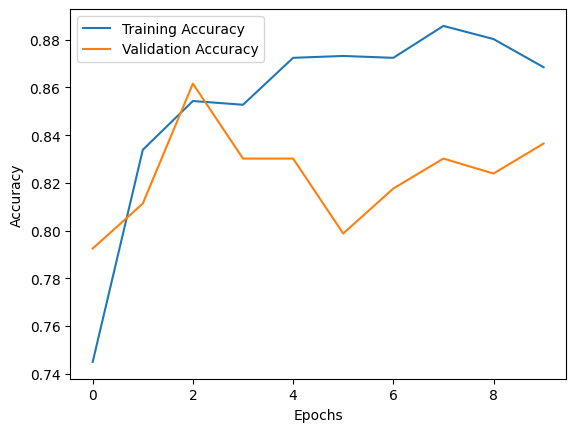

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7477 - loss: 0.6169
Test Accuracy: 74.84%


# Retrain

In [ ]:
from tensorflow.keras import layers

# Apply data normalization and augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),  # Random horizontal flip
    layers.RandomRotation(0.2),  # Random rotation
    layers.RandomZoom(0.2),  # Random zoom
])

# Apply normalization after augmentation
normalization_layer = layers.Rescaling(1./255)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load MobileNetV2 pre-trained model (exclude top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # Three output classes: normal, benign, malignant
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels from the train_dataset
labels = []
for image, label in train_dataset:
    labels.extend(label.numpy())  # Convert to numpy array and add to list

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Create a dictionary for class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")


Class weights: {0: 0.5945692883895131, 1: 1.241446725317693, 2: 1.9508448540706604}


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract labels from the train_dataset
labels = []
for image, label in train_dataset:
    labels.extend(label.numpy())  # Convert to numpy array and add to list

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in np.unique(labels)}
print(f"Class weights: {class_weight_dict}")

# Now, train the model with class weights
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    class_weight=class_weight_dict  # Pass the class weight dictionary here
)


Class weights: {0: 0.5945692883895131, 1: 1.241446725317693, 2: 1.9508448540706604}
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7707 - loss: 0.4428 - val_accuracy: 0.7736 - val_loss: 0.5315
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8014 - loss: 0.4205 - val_accuracy: 0.7610 - val_loss: 0.5314
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7903 - loss: 0.4354 - val_accuracy: 0.7673 - val_loss: 0.5148
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7776 - loss: 0.4290 - val_accuracy: 0.7862 - val_loss: 0.5153
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8067 - loss: 0.4112 - val_accuracy: 0.7484 - val_loss: 0.5375
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7994 - loss: 0.4141 - val_accuracy: 0.7925 - val_loss: 0.5133
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8079 - loss: 0.4147 - val_accuracy: 0.7673 - val_loss: 0.4861
Epoch 8/10
40/40 ━━━━━━━━━━━

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7477 - loss: 0.6169
Test accuracy: 74.84%


# Improving to more accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory paths
data_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'

# Load datasets from the directories
train_dataset = image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),  # Resize images to 224x224 for input
    batch_size=32,
    label_mode='int',  # Labels are categorical (malignant, benign, normal)
    shuffle=True
)

# Normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))

# Define the model architecture
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10  # You can adjust the number of epochs
)

# Evaluate model performance
test_loss, test_acc = model.evaluate(test_dataset)  # Assuming test_dataset is loaded similarly
print(f"Test accuracy: {test_acc:.2f}")


Found 1588 files belonging to 3 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.5388 - loss: 1.3723
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.7211 - loss: 0.6369
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.7994 - loss: 0.4685
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.8607 - loss: 0.3396
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 4s/step - accuracy: 0.9220 - loss: 0.1976
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.9414 - loss: 0.1718
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.9561 - loss: 0.1261
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.9834 - loss: 0.0698
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.9885 - loss: 0.0445
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 187s 4s/step - accuracy: 0.9816 - loss: 0.0667
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 878ms/step - accuracy: 0.9588 - loss: 12.5261
Test accuracy: 0.94


# class maping and saving

In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model('breast_cancer_classifier_model.keras')  # Ensure the model file exists in your working directory

# Streamlit interface
st.title('Breast Cancer Classification')
st.write('Upload an ultrasound image to classify it as normal, benign, or malignant.')

# File uploader
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

# Define class names based on training labels
class_names = ["Normal", "Benign", "Malignant"]

if uploaded_file is not None:
    # Load and preprocess the image
    img = image.load_img(uploaded_file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display result
    st.image(uploaded_file, caption=f"Predicted: {class_names[predicted_class]}", use_column_width=True)
    st.write(f"### Prediction: **{class_names[predicted_class]}**")



2025-02-03 09:19:39.484 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.611 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-03 09:19:39.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.617 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-03 09:19:39.626 Thread 'MainThread': mi

In [ ]:
model.save('breast_cancer_classifier_model.keras')



In [ ]:
model.save('/content/drive/MyDrive/breast_cancer_classifier_model.keras')

